# Horse Rank Prediction by Classification

## 패키지 로드 & 옵션 정의

In [0]:
import numpy as np
import pandas as pd

pd.options.display.max_rows = 20
pd.options.display.max_columns = 20

In [3]:
from google.colab import drive
drive.mount('/content/drive')
!cp "/content/drive/My Drive/Colab Notebooks/race_result_1219.csv" "race_result.csv"
#!cp "/content/drive/My Drive/Colab Notebooks/race.csv" "race.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## race_result 로드 & 기초 인코딩

In [0]:
result = pd.read_csv('race_result.csv')

result = result.iloc[::-1]
result = result.reset_index().drop('index', axis=1)

# groupid 추가
result['groupid'] = result['date'].apply(str) + result['round'].apply(str)
idset = list(set(result['groupid']))
give_ids = dict(list(zip(idset, list(range(len(idset))))))
result['groupid'] = result['groupid'].apply(lambda x: give_ids[x])

# 필요 변수만 선택
result_df = result[ 
    ['date','round','groupid','rank', 'lane', 'sex', 'age','new_distance', 'prev1_rank', 'prev2_rank', 'prev3_rank', 'dandivi', 'yeondivi' ,
      'jockey_w', 'raw_weight', 'weight_added' , 'prev1_velo', 'prev2_velo', 'prev3_velo',
    'cure_in_1m', 'jprev1_rank', 'jprev2_rank', 'jprev3_rank','prev_velo_avg','prev_rank_avg']
]

# 결측치있는 raw 제거
result_nonan = result_df.dropna()

# sex 더미변수화
sex = pd.get_dummies(result_nonan.sex)
sex.columns = ['neut', 'male', 'female']
result_nonan = result_nonan.drop('sex', axis=1)
result_nonan = sex.join(result_nonan)

# weight, velocity 표준화
from sklearn import preprocessing
standadized_result = result_nonan[['jockey_w', 'raw_weight', 'weight_added', 'prev1_velo', 'prev2_velo', 'prev3_velo']]
scaler = preprocessing.StandardScaler().fit(standadized_result)
preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)
result_nonan[['jockey_w', 'raw_weight', 'weight_added', 'prev1_velo', 'prev2_velo', 'prev3_velo']] = scaler.transform(standadized_result)

#display(result_nonan)

In [0]:
# 1~3등: 1, 나머지: 0
ranks_replace = {
    'rank': {'1': 1, '2': 1, '3': 1, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0, '10': 0, '11': 0, '12': 0, '13': 0, '14': 0, '15': 0, '16': 0, '실': None, '제': None, '중': None, '취': None},
    'prev1_rank' : {'실': None, '제': None, '중': None, '취': None},
    'prev2_rank' : {'실': None, '제': None, '중': None, '취': None},
    'prev3_rank' : {'실': None, '제': None, '중': None, '취': None},
    'jprev1_rank': {'실': None, '제': None, '중': None, '취': None}, 
    'jprev2_rank': {'실': None, '제': None, '중': None, '취': None},
    'jprev3_rank': {'실': None, '제': None, '중': None, '취': None}
}
result_binary = result_nonan.replace(ranks_replace, inplace=False)
result_binary = result_binary.dropna()

cols = ['prev1_rank','prev2_rank','prev3_rank','jprev1_rank','jprev2_rank','jprev3_rank']
result_binary[cols] = result_binary[cols].apply(pd.to_numeric, errors='coerce', axis=1)

# prev_rank 평균으로 대체
result_binary['prev_rank_mean'] = (result_binary['prev1_rank']+result_binary['prev2_rank']+result_binary['prev3_rank'])/3
result_binary = result_binary.drop(['prev1_rank','prev2_rank','prev3_rank'], axis=1)

#display(result_binary.shape, result_binary.dtypes)

In [0]:
rank = result_binary['rank']
result_binary.drop(labels=['rank'], axis=1,inplace = True)
result_binary.insert(0, 'rank', rank)

In [0]:
result_binary.shape

(48828, 25)

## 학습데이터 분리

In [0]:
# test set 1) 2017.09 ~ 2018.09   2) 2018.03 ~ 2018.09
result_binary['year'] = pd.DatetimeIndex(result_binary['date']).year
result_binary['month'] = pd.DatetimeIndex(result_binary['date']).month
test_set1 = result_binary[((result_binary.year == 2017) & (result_binary.month >=9))|((result_binary.year == 2018) & (result_binary.month <=9))]
train_set1 = result_binary[((result_binary.year <= 2017) & (result_binary.month < 9))|((result_binary.year >= 2018) & (result_binary.month > 9))]
test_set2 = result_binary[(result_binary.year == 2018) & (result_binary.month >=3) & (result_binary.month <=9)]
train_set2 = result_binary[((result_binary.year <= 2018) & (result_binary.month < 3))|((result_binary.year >= 2018) & (result_binary.month > 9))]

In [0]:
test1 = test_set1.drop(['date','round','groupid','year','month'],axis=1)
train1 = train_set1.drop(['date','round','groupid','year','month'],axis=1)
test2 = test_set2.drop(['date','round','groupid','year','month'],axis=1)
train2 = train_set2.drop(['date','round','groupid','year','month'],axis=1)

In [0]:
x_train = train2.iloc[:, 1:]
y_train = train2['rank'].astype(int)

x_test = test2.iloc[:, 1:]
y_test = test2['rank'].astype(int)

#print_shape((x_train, y_train, x_test, y_test))
#display(x_train, y_train, x_test, y_test)

In [0]:
test2.shape

(5162, 22)

## NN 모델

## 필요 함수 정의

In [4]:
from keras import backend as K

def print_shape(dfs):
    for df in dfs:
        print(df.shape)

def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

Using TensorFlow backend.


In [13]:
!pip install keras_metrics

In [0]:
# 1. 사용할 패키지 불러오기
from keras.models import Sequential
from keras.layers import Dense
import keras_metrics
import keras
import random
from sklearn.utils import class_weight
from keras import callbacks
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization

In [0]:
# 2. 모델 구성하기
xavier = keras.initializers.glorot_normal(seed=None)

model = Sequential()
model.add(Dense(16, input_dim=21, kernel_initializer=xavier, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout (0.2))
model.add(Dense(8, input_dim=21, kernel_initializer=xavier, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout (0.2))
model.add(Dense(1, activation='sigmoid'))

In [0]:
# 3. 모델 학습과정 설정하기
sgd = keras.optimizers.SGD(lr=0.1, momentum=0.0, decay=0.0, nesterov=False)
adadelta = keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
rmsprop = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [33]:
# 4. 모델 학습시키기
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy', recall, precision, f1score])   # accuracy, recall, precision, f1score

class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

hist = model.fit(x_train, y_train, epochs=500, class_weight=class_weights)

Epoch 1/500
8081/8081 [==============================] - 1s 156us/step - loss: 0.5300 - acc: 0.7342 - recall: 0.3420 - precision: 0.5067 - f1score: 0.3832
Epoch 2/500
8081/8081 [==============================] - 0s 54us/step - loss: 0.4983 - acc: 0.7536 - recall: 0.3045 - precision: 0.5461 - f1score: 0.3728
Epoch 3/500
8081/8081 [==============================] - 0s 54us/step - loss: 0.4896 - acc: 0.7578 - recall: 0.2905 - precision: 0.5760 - f1score: 0.3637
Epoch 4/500
8081/8081 [==============================] - 0s 53us/step - loss: 0.4818 - acc: 0.7635 - recall: 0.3163 - precision: 0.5889 - f1score: 0.3920
Epoch 5/500
8081/8081 [==============================] - 0s 54us/step - loss: 0.4829 - acc: 0.7603 - recall: 0.3164 - precision: 0.5812 - f1score: 0.3887
Epoch 6/500
8081/8081 [==============================] - 0s 51us/step - loss: 0.4777 - acc: 0.7714 - recall: 0.3350 - precision: 0.6103 - f1score: 0.4128
Epoch 7/500
8081/8081 [==============================] - 0s 52us/step - los

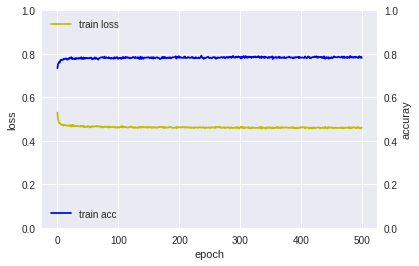

5162/5162 [==============================] - 0s 57us/step
loss_and_metrics : [0.49899591897541773, 0.7553273924835335, 0.3204356423185482, 0.6635178988499957, 0.41902422600132416]


In [34]:
# 5. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.set_ylim([0.0, 1.0])
acc_ax.set_ylim([0.0, 1.0])

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
acc_ax.plot(hist.history['acc'], 'b', label='train acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# 6. 모델 평가하기
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=32)
print('loss_and_metrics : ' + str(loss_and_metrics))

## 허용치 설정 후 precision 계산

In [38]:
pred = model.predict(x_test)
yt = np.array(y_test)
predictions = [0 for x in range(pred.shape[0])]
for i, predicted in enumerate(pred):
    if predicted[0] >= 0.4:
        predictions[i] = 1
    else:
        predictions[i] = 0
        
df = pd.DataFrame({'prediction' : predictions, 'real' : yt})
df['accurate'] = df['prediction'] == df['real']

display(
    df[df['prediction'] == 1].shape[0] / df.shape[0],
    df[df['prediction'] == 1].accurate.mean()
)

0.23266175900813638

0.5970024979184013

In [0]:
pred = model.predict(x_test)
yt = np.array(y_test)
predictions = [0 for x in range(pred.shape[0])]
for i, predicted in enumerate(pred):
    predictions[i] = predicted[0]
        
df = pd.DataFrame({'prediction' : predictions, 'real' : yt})

In [0]:
df = df.reset_index(drop=True)
test_set2 = test_set2.reset_index(drop=True)
data = test_set2.join(df)

In [0]:
data.to_csv('/content/drive/My Drive/NN_pred2.csv')